# Twitter Sentiment Classification

### Project Overview
**Motivation:** Social media has become an indispensable platform for many businesses to directly interact with consumers and to market products. Using AI to automatically identify whether a tweet is a positive or negative response allows businesses to quickly grasp customer reactions without going through every tweet. 

**Deliverables:** In this project, I developed a Logistic Regression model to classify the sentiment (positive or negative) of tweets, to an accuracy of 77%. This trained model is useful for gauging overall consumer reactions to a new product, or for quickly locating negative responses, which usually require special attention from customer service.

### Project Details 
**The Data**: This big dataset contains 1600k tweets with labeled polarity.
- polarity labels: 0 = negative, 4 = positive <br>
- The data is automatically labeled by the rule that the presence of a **sad emoji** indicates negative sentiment and a **happy emoji** indicates positive sentiment. 
- http://help.sentiment140.com/for-students <br>

**The Model**: Using a small subset (5%, 80k) of the total data, I compared a Naive Bayes model with a Logistic Regression model. The two models have similar performance, but Logistic Regression won by a tad. With a Logistic Regression model, I can classify the polarity of a tweet with 77% accuracy. This is a great performance considering that human analysts only agree around 80-85% of the time. 

**Next Steps**: 
* It's unknown how generalizable this model is when applied to specific businesses or products. It will be interesting to test it on a more specific dataset. 
* An unexplored approach is to look at phrases (bigram) instead of just single words (unigram). This could help in cases such as differentiating between "good" and "not good". 
* Another possibility is to analyze punctuations. Exclamation mark, for instance, indicates strong emotions. 
* SVM or Random Forest?
* And a neural network is always another option. LOL. 

In [1]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# loading data
noemo = pd.read_csv('data/noemoticon.csv',encoding = "ISO-8859-1",header = None)
noemo.columns = ['polarity','id','date','query','user','tweet']
noemo.head(2)

,polarity,id,date,query,user,tweet
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...


### Exploratory Analysis 0: check for sample bias

In [3]:
noemo.groupby('polarity').id.count()
# Comments: the data contains equal amount of negative(0) and positive(4) data

polarity
0    800000
4    800000
Name: id, dtype: int64

### Exploratory Analysis 1: length of tweet for either polarity

In [4]:
# get length of tweets 
noemo['tweet_len'] = [len(i) for i in noemo.tweet]

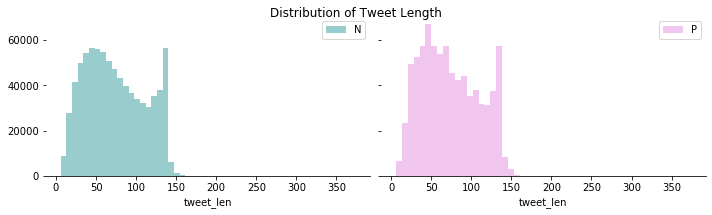

In [5]:
# Plot distribution of tweet length 
f, axes = plt.subplots(1,2,figsize=(10, 3), sharex=True, sharey=True)
sns.despine(left=True)
# negative tweets
sns.distplot(noemo['tweet_len'][noemo.polarity == 0], color='teal', kde=False, ax=axes[0],bins=50)
axes[0].legend('Negative')
# positive tweets
sns.distplot(noemo['tweet_len'][noemo.polarity == 4], color='orchid',kde=False, ax=axes[1],bins=50)
axes[1].legend('Positive')
plt.suptitle('Distribution of Tweet Length')
plt.tight_layout()

#Comments: The distribution of tweet length is similar between negative and positive data. 

### Exploratory Analysis 2: preprocess tweets & check if high frequency words align with each polarity

In [100]:
# as the dataset is large and nlp is slow, take about 40k (5%) samples from each category to explore the data 
neg_df = noemo[noemo.polarity==0].sample(frac=0.05, random_state = 101)
posi_df = noemo[noemo.polarity==4].sample(frac=0.05, random_state = 101)
toy_df = pd.concat((neg_df,posi_df))

In [113]:
# define functions to preprocess the texts, through the following steps:
# - remove website links, keep on alphas
# - tokenize and lemmatize the tokens
# - remove stopwords
# - perform stemming
# - keep words longer than 2 characters.  

import nltk
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import SnowballStemmer
import re
import pickle

def to_alpha(texts):
    """
    Take a string, remove website links, return only alphas
    """
    texts = re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '', texts) # remove website links
    return(' '.join([w.lower() for w in nltk.word_tokenize(texts) if w.isalpha()]))
def token_lem_stem(texts,printout=None):
    """
    Take a string, do the following: 
    1. tokenize and lemmatize the tokens, remove stopwords
    2. convert to stems 
    3. keep words longer than 2 characters
    """
    texts = to_alpha(texts)
    tokens = nltk.word_tokenize(texts) # tokenize 
    lemmatizer = WordNetLemmatizer() # lemmatize & remove stop words
    token_lem = [lemmatizer.lemmatize(word) for word in tokens if word not in stopwords.words('English')]
    stemmer = SnowballStemmer("english") # stem
    stemmed_words=[stemmer.stem(word) for word in token_lem]
    # keep words longer than 2
    words_len = [word for word in stemmed_words if len(word)>2]  
    if printout != None:
        print('No. of unique words \nbefore processing:', len(set(stemmed_words)))
        print('after processing:', len(set(words_len)))
        
    return words_len
    

In [394]:
#Try out the function "token_lem_stem" 
print('Negative Example')
print('Before: '+toy_df['tweet'].iloc[3])
print('After: '+str(token_lem_stem(toy_df['tweet'].iloc[3])))

print('\nPositive Example')
print('Before: '+toy_df['tweet'].iloc[-10])
print('After: '+str(token_lem_stem(toy_df['tweet'].iloc[-10])))

Negative Example
Before: @jakehumphreyf1 Wish I was there but I have an exam tomorrow and on Tuesday so I can't  Have fun for me!!
After: ['wish', 'exam', 'tomorrow', 'tuesday', 'fun']

Positive Example
Before: talking to my lovely amazing sister!! about to wash my white clothes and change the strings on my guitar for tomorrow.  yay for worship!
After: ['talk', 'love', 'amaz', 'sister', 'wash', 'white', 'cloth', 'chang', 'string', 'guitar', 'tomorrow', 'yay', 'worship']


In [396]:
# apply "token_lem_stem", keep the results in a new column called 'tokens'
toy_df['tokens'] = toy_df['tweet'].apply(token_lem_stem)
toy_df.to_csv('data/toy_df.csv')

In [110]:
# # Uncomment if needed. To re-load toy_df
# from ast import literal_eval

# toy_df = pd.read_csv('data/toy_df.csv', index_col=0)
# # convert the column 'tokens' into lists, otherwise pandas read it in as a string
# toy_df.tokens = toy_df.tokens.apply(literal_eval) 

In [118]:
# Merge all rows into a large string for word frequency analysis
neg_bits = [a for b in toy_df['tokens'][toy_df.polarity == 0].tolist() for a in b]
posi_bits = [a for b in toy_df['tokens'][toy_df.polarity == 4].tolist() for a in b]

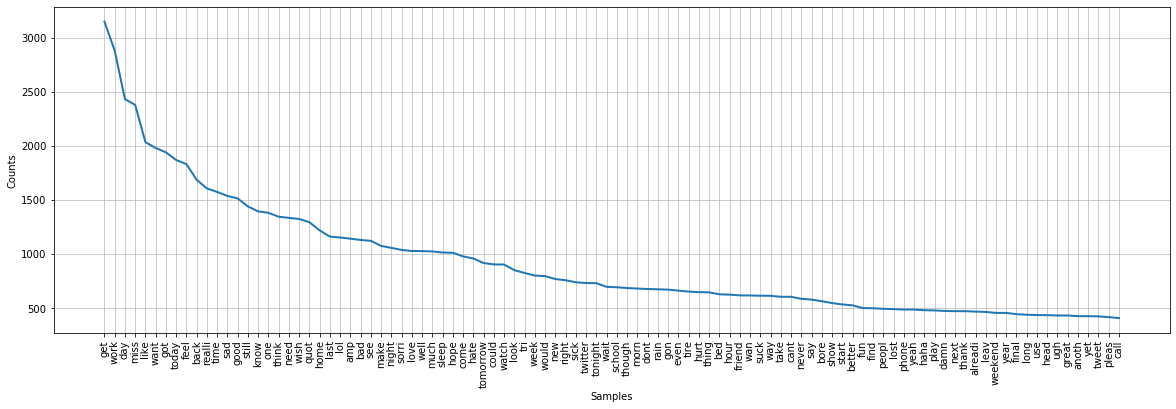

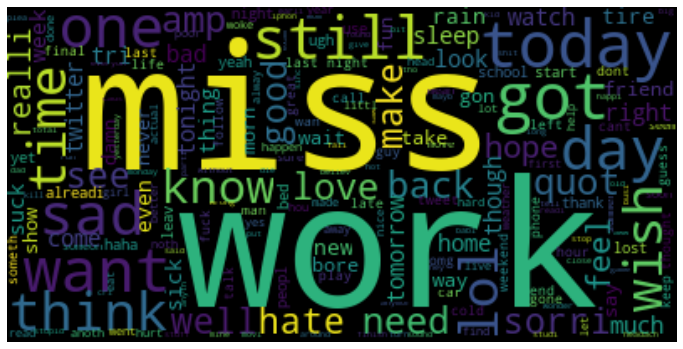

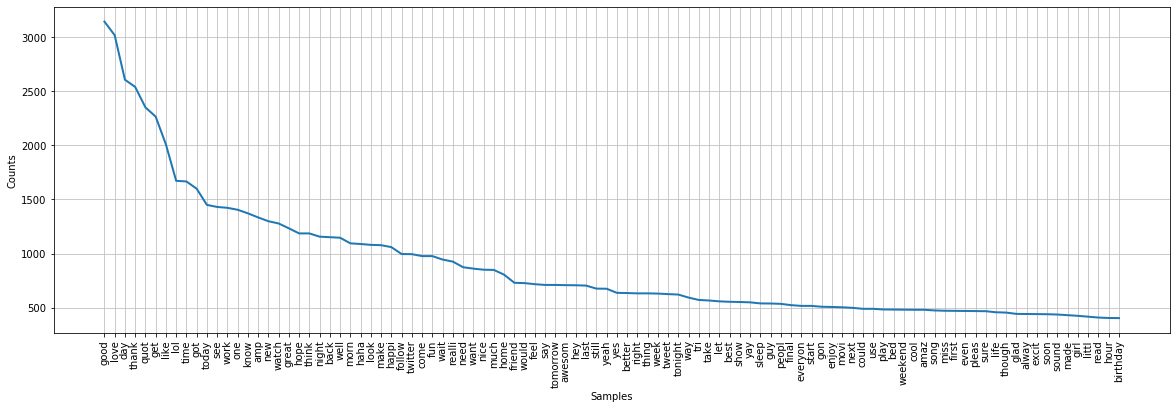

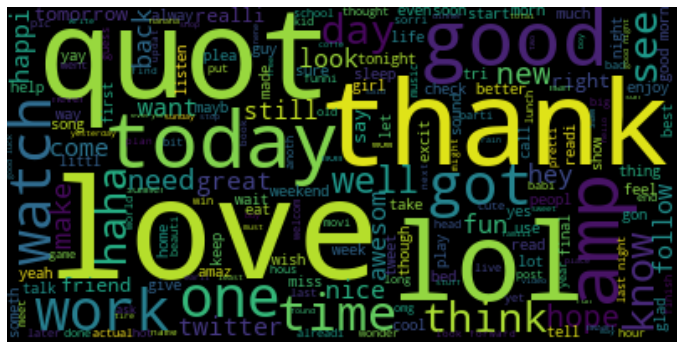

In [119]:
# find and visualize the top 100 most common words for each polarity
from wordcloud import WordCloud

neg_fdist = nltk.FreqDist(neg_bits)
posi_fdist = nltk.FreqDist(posi_bits)
 
plt.figure(figsize = (20,6))
neg_fdist.plot(100)
wcloud = WordCloud(margin=0).generate(" ".join(neg_bits))
plt.figure(figsize = (12, 8))
plt.imshow(wcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

plt.figure(figsize = (20,6))
posi_fdist.plot(100)
wcloud = WordCloud(margin=0).generate(" ".join(posi_bits))
plt.figure(figsize = (12, 8))
plt.imshow(wcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# Comments: notice that some words have high-frequency for both polarities. e.g. get, think, today... 


### Exploratory Analysis 3: find high frequency words unique to each polarity 

In [123]:
# sort the words according to their frequencies
neg_key_sorted= sorted(neg_fdist , key = neg_fdist.__getitem__, reverse = True)
posi_key_sorted = sorted(posi_fdist , key = posi_fdist.__getitem__, reverse = True)

In [124]:
# find words unique to each polarity among the top 100 words
n_wd= 100
neg_unique = [i for i in neg_key_sorted[:n_wd] if i not in posi_key_sorted[:n_wd]]
posi_unique = [i for i in posi_key_sorted[:n_wd] if i not in neg_key_sorted[:n_wd]]
print('The No. of unique words among top 100 words: '+str(len(neg_unique)))
neg_unique_fdist = [neg_fdist[i] for i in neg_unique]
posi_unique_fdist = [posi_fdist[i] for i in posi_unique]

The No. of unique words among top 100 words: 29


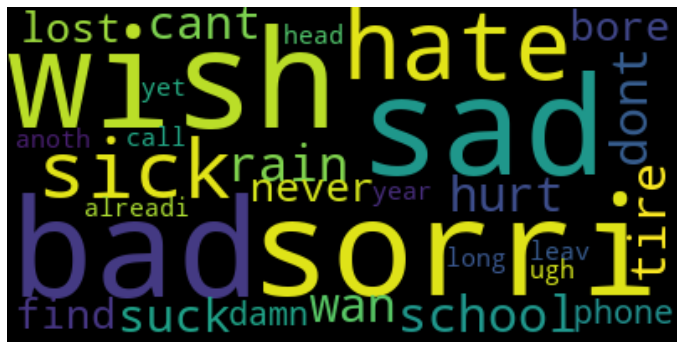

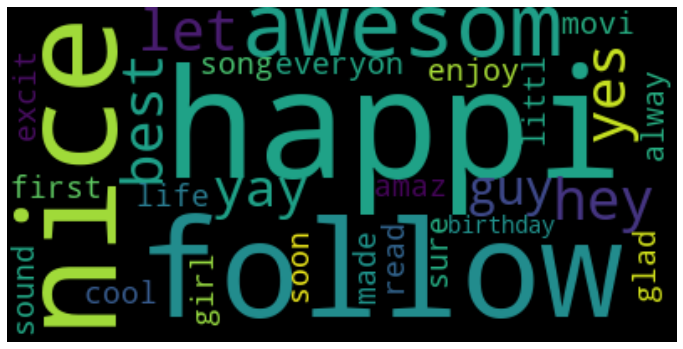

In [125]:
# do wordcloud to show unique words in each category
from wordcloud import WordCloud

for i in [neg_unique,posi_unique]:    
    wcloud = WordCloud(margin=0).generate(" ".join(i))
    plt.figure(figsize = (12, 8))
    plt.imshow(wcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

## Comments 
Among the top 100 words, there are 29 words unique to each category. Most of these words align with their respective categories. However, there are some potential misalignments, for instance, the word *"guy"* is in the Positive category, but it's hard to understand why it's associated with positivity. 

Another drawback is that unigram analysis doesn't pick up polarity expressed by phrases. For instance, the most frequent word in the Positive category is "good",  but this word is also among the top 100 word in the Negative category, potentially because it's present in the phrase "not good". 




# Training and Validating Classification Models

### Step 1: converting data into a weighted matrix

In [150]:
from sklearn.feature_extraction.text import CountVectorizer
# Vectorize the data with the bag-of-words model. 

# To directly use tokenized data, create a dummy function as analyzer
def dummy(tokens):
    return tokens

toy_CV = CountVectorizer(analyzer = dummy).fit(toy_df.tokens)

# Print total number of vocab words
print('Number of words in the vocabulary: '+str(len(toy_CV.vocabulary_)))

# transform 
toy_bow = toy_CV.transform(toy_df.tokens)

Number of words in the vocabulary: 57142


In [127]:
from sklearn.feature_extraction.text import TfidfTransformer
# Use tf-ifd (term frequency–inverse document frequency) to transform the data according to their saliency 

toy_tfidf_transformer = TfidfTransformer().fit(toy_bow)
toy_tfidf = toy_tfidf_transformer.transform(toy_bow)

In [282]:
# get the idf_weights for each word in the vovabulary
toy_idf = pd.DataFrame(toy_tfidf_transformer.idf_, index=toy_CV.get_feature_names(),columns=["idf_weights"])
toy_idf.sort_values(by=["idf_weights"])
# comment: common words like "get", "day" have low idf_weights, and more unique words have higher idf_weights. 

,idf_weights
get,3.736655
day,3.818645
good,3.883086
work,3.969346
like,4.026720
...,...
coldsaw,11.596647
limauai,11.596647
coldmilk,11.596647
lilslut,11.596647


In [261]:
from sklearn.model_selection import train_test_split
# Split the data into 80% training set & 20% validation set. 

tweet_train, tweet_vali, pol_train, pol_vali = train_test_split(toy_tfidf, toy_df.polarity, test_size=0.2, random_state = 101)

### Step 3: Train and Evaluate a Naive Bayes model and a Logistic Regression model

In [142]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
# fit a Naive Bayes model and use the validation set to check performance. 

NBmodel = MultinomialNB().fit(tweet_train, pol_train)
NBpredictions = NBmodel.predict(tweet_vali)
print (classification_report(pol_vali, NBpredictions))

              precision    recall  f1-score   support

           0       0.71      0.78      0.74      7910
           4       0.76      0.68      0.72      8090

    accuracy                           0.73     16000
   macro avg       0.73      0.73      0.73     16000
weighted avg       0.73      0.73      0.73     16000



In [130]:
from sklearn.linear_model import LogisticRegression
# fit a Logistic Regression model and use the validation set to check performance. 

logmodel = LogisticRegression().fit(tweet_train, pol_train)
logpredictions = logmodel.predict(tweet_vali)
print (classification_report(pol_vali, logpredictions))

C:\Users\Huayi\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


              precision    recall  f1-score   support

           0       0.76      0.72      0.74      7910
           4       0.74      0.78      0.76      8090

    accuracy                           0.75     16000
   macro avg       0.75      0.75      0.75     16000
weighted avg       0.75      0.75      0.75     16000



#### comments
The Naive Bayes classifier and the Logistic Regression classifier performed very similarly. Logistic Regression classifier seems a tiny bit better. 

### Step 4: Further evaluate the LR model by looking into words that best classified the two polarities. 

* Recall that the LR model is a sigmoidal curve with a shape specified by the term 
$\Theta X = \theta_0 x_0 + \theta_1 x_1 + \theta_2 x_2+ ...+\theta_n x_n$. <br>
* Thus, $\theta_n x_n$ roughly indicates the importance of the nth word. <br>
* Negative tweets are likely to contain words with negative coefficients, and positive tweets are the opposite. <br> 
* Here, I created a column named "product" that contains the product of each coefficient and its corresponding idf_weight. <br> 
* I used that product as a proxy to look at important words from each polarity classified by the LR model. 


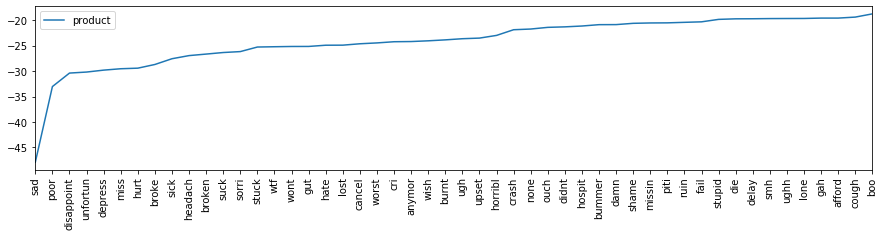

In [402]:
# negative polarity correlates with negative coefficient. 
neg_coef = pd.DataFrame((toy_idf[logmodel.coef_[0]<0].values.T *logmodel.coef_[0][logmodel.coef_[0]<0]).T, index=toy_idf[logmodel.coef_[0]<0].index,columns=["product"])
ax = neg_coef.sort_values(by=["product"])[:50].plot(xticks=range(50), rot=90,figsize=[15,3])
ax.set_xticklabels(neg_coef.sort_values(by=["product"]).index[:50])
plt.show()

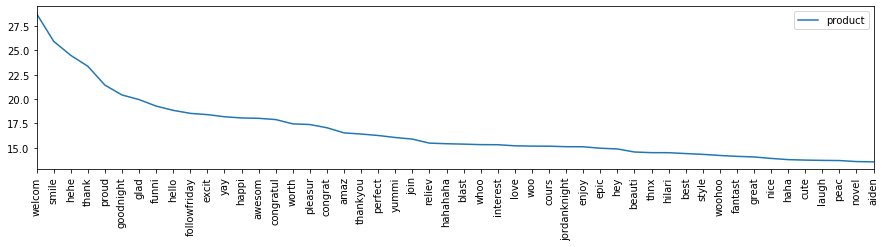

In [370]:
# positive polarity correlates with positive coefficient. 
posi_coef = pd.DataFrame((toy_idf[logmodel.coef_[0]>0].values.T *logmodel.coef_[0][logmodel.coef_[0]>0]).T, index=toy_idf[logmodel.coef_[0]>0].index,columns=["product"])
ax = posi_coef.sort_values(by=["product"],ascending=False)[:50].plot(xticks=range(50), rot=90,figsize=[15,3])
ax.set_xticklabels(posi_coef.sort_values(by=["product"],ascending=False).index[:50])
plt.show()

#### Comment:  top words aligns well with the polarity. This is an indication that the classification model makes sense. 


## Classify the whole dataset

Run Logistic Regression on the entire dataset

In [94]:
# apply "token_lem_stem", keep the results in a new column called  'tokens'
noemo['tokens'] = noemo['tweet'].apply(token_lem_stem)
noemo.to_csv('data/noemo.csv')

In [140]:
# # Uncomment if needed. To re-load noemo

# noemo = pd.read_csv('data/noemo.csv', index_col=0)
# #convert the column 'tokens' into lists, otherwise pandas read it in as a string
# noemo.tokens = noemo.tokens.apply(literal_eval) 

In [208]:
# split the dataset twice, such that train:test:validation = 2:6:2. 
# A small training set is used to test how well a model trained with limited data can handle the unlimited data on the internet.

tweet_chunck, tweet_test, pol_chunck, pol_test = train_test_split(noemo['tokens'], noemo['polarity'], test_size=0.6, random_state=101)
tweet_train, tweet_vali, pol_train, pol_vali = train_test_split(tweet_chunck, pol_chunck, test_size=0.5, random_state=101)

In [209]:
from sklearn.pipeline import Pipeline

# create a pipeline 
pipeline = Pipeline([ ('CV', CountVectorizer(analyzer=dummy)), 
                    ('tfidf', TfidfTransformer()),  
                    ('classifier', LogisticRegression()),])

In [215]:
pipeline.fit(tweet_train,pol_train)

C:\Users\Huayi\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Pipeline(memory=None,
         steps=[('CV',
                 CountVectorizer(analyzer=<function dummy at 0x0000024554ABBF28>,
                                 binary=False, decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 to...
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('classifier',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scali

In [217]:
# evaluate with the validation set. 
vali_predictions = pipeline.predict(tweet_vali)
print(classification_report(vali_predictions,pol_vali))

# Comment: the model seems to perform well, exceding slightly the model trained and tested on toy_df.

              precision    recall  f1-score   support

           0       0.75      0.78      0.76    153765
           4       0.79      0.76      0.77    166235

    accuracy                           0.77    320000
   macro avg       0.77      0.77      0.77    320000
weighted avg       0.77      0.77      0.77    320000



In [218]:
# evaluate with the test set. 
predictions = pipeline.predict(tweet_test)
print(classification_report(predictions,pol_test))

# Comment: performed the same as the validation set. 

              precision    recall  f1-score   support

           0       0.75      0.78      0.76    461599
           4       0.79      0.76      0.77    498401

    accuracy                           0.77    960000
   macro avg       0.77      0.77      0.77    960000
weighted avg       0.77      0.77      0.77    960000

